# Prepare Google Colab Environment

In [1]:
!git clone https://github.com/mhamilton723/STEGO.git

Cloning into 'STEGO'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 186 (delta 13), reused 12 (delta 12), pack-reused 169
Receiving objects: 100% (186/186), 9.09 MiB | 27.21 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [2]:
!pip install wget
!pip install torchmetrics
!pip install hydra-core
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install omegaconf
!pip install pytorch-lightning

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=1c215adb5a90d624606d82fa5cb3244020941f8ca5ee764c40d0564ae943a04a
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 409 kB 12.7 MB/s 
     |████████████████████████████████| 147 kB 11.9 MB/s 
     |████████████████████████████████| 112 kB 51.6 MB/s 
     |████████████████████████████████| 74 kB 3.3 MB/s 
     |████████████████████████████████| 596 kB 48.8 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=4d429bacd05f94c444048255f4f65943789786749afb53ea0334fdea0ced6b0e
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
  

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-3adgxynl
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-3adgxynl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2778822 sha256=0b3f064e62ce8efc75cb00549101aa6530564035b69baeae1be9d0a9020860e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-oqy9hkud/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf
     |████████████████████████████████| 584 kB 11.4 MB/s 
     |████████████████████████████████| 136 kB 50.7 MB/s 
     |████████████████████████████████| 1.1 MB 46.7 MB/s 
     |████████████████████████████████| 271 kB 56.3 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 54.8 MB/s 


# Download Pretrained Model



In [3]:
import os
from os.path import join
os.chdir("STEGO/src")
saved_models_dir = join("..", "saved_models")
os.makedirs(saved_models_dir, exist_ok=True)

In [4]:
import wget
saved_model_url_root = "https://marhamilresearch4.blob.core.windows.net/stego-public/saved_models/"
saved_model_name = "cocostuff27_vit_base_5.ckpt"
if not os.path.exists(join(saved_models_dir, saved_model_name)):
  wget.download(saved_model_url_root + saved_model_name, join(saved_models_dir, saved_model_name))

# Load pretrained STEGO

In [5]:
from train_segmentation import LitUnsupervisedSegmenter

model = LitUnsupervisedSegmenter.load_from_checkpoint(join(saved_models_dir, saved_model_name)).cuda()

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_vitbase8_pretrain.pth


  0%|          | 0.00/327M [00:00<?, ?B/s]

# Load Image

In [8]:
from PIL import Image
import requests
from io import BytesIO
from torchvision.transforms.functional import to_tensor
from utils import get_transform

img_url ="https://marhamilresearch4.blob.core.windows.net/stego-public/sample_images/moto1.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
transform = get_transform(448, False, "center")
img = transform(img).unsqueeze(0).cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


# Query model and pass result through CRF

In [10]:
import torch.nn.functional as F
from crf import dense_crf
import torch

with torch.no_grad():
  code1 = model(img)
  code2 = model(img.flip(dims=[3]))
  code  = (code1 + code2.flip(dims=[3])) / 2
  code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
  linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
  cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

  single_img = img[0].cpu()
  linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
  cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

# Visualize Result

Note that cluster predictions will not be matched with ground truth classes in this example. For hungarian matching please use: `eval_segmentation.py`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


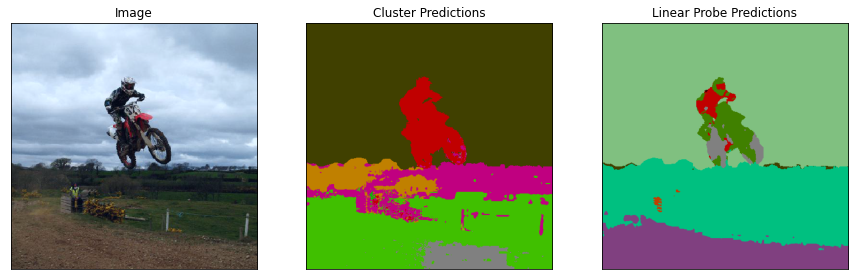

In [12]:
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes
fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[0].set_title("Image")
ax[1].imshow(model.label_cmap[cluster_pred])
ax[1].set_title("Cluster Predictions")
ax[2].imshow(model.label_cmap[linear_pred])
ax[2].set_title("Linear Probe Predictions")
remove_axes(ax)